# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


## Data

In [2]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)

In [3]:
#DATA_DF.content[0]

In [4]:
# remove all double-quotation marks
# TODO: "ZeroDivisionError: Weights sum to zero, can't be normalized" in validate of fastai/model.py when I do this
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [5]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [6]:
# build special genre_content column for conditioned reviews later on
# note that we are also removing punctuation and spacing in genre names for this
#import re
#import string

#GENRE_REGEX = re.compile(f'[{re.escape(string.punctuation)}{re.escape(string.whitespace)}]')

#DATA_DF = DATA_DF.assign(genre_content=lambda x: None)
#DATA_DF.genre_content = DATA_DF.genres.apply(lambda x: ' '.join([f'genre{GENRE_REGEX.sub("", g.upper())}' for g in x])  if x is not None else 'none') + ' ' + DATA_DF.content
#DATA_DF.genre_content.head()

In [7]:
SAMPLE_DF = DATA_DF.sample(250) # overfit to 250 songs
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,pages_rendered,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str
50637,Fossil Collective,None,Clayton Warwick,Fossil Collective\nDo You Realize (The Flaming...,2013-11-06T00:00:00.000Z,NaN,None,ltr,www.themusicninja.com,NaN,...,NaN,Fossil Collective – Do You Realize (The Flamin...,http://www.themusicninja.com/fossil-collective...,1.0,The Music Ninja,Do You Realize (The Flaming Lips cover),None,1,199,none
11485,EDEN,"{'danceability': 0.577, 'energy': 0.507, 'key'...",None,"I posted Eden's 'Gravity' about a year ago, un...",None,NaN,\n\n“sex” is the first single released from ED...,ltr,musicthatwelike.com,NaN,...,NaN,sex,http://musicthatwelike.com/post/147927925650/e...,1.0,Music That We Like,sex,26ZX2JrAb8AFbr8FFfAsO7,1,47,rock/pop
52600,London Grammar,None,None,London Grammar is an interesting up-and-comin...,2013-07-25T20:28:51.000Z,NaN,None,ltr,earmilk.com,NaN,...,NaN,"London Grammar - ""Wasting My Young Years"" (Hen...",http://www.earmilk.com/2013/07/25/london-gramm...,1.0,EARMILK,Wasting My Young Years (Henrik Schwarz Remix),None,1,138,none
1836,Evalyn,"{'danceability': 0.607, 'energy': 0.55, 'key':...",Indietronica Staff,"Evalyn\nNewcomer, Evalyn , shares her official...",2017-02-15T15:02:45.000Z,NaN,\n\n?\n\n,ltr,indietronica.org,NaN,...,NaN,Evalyn – Filthy Rich,http://indietronica.org/2017/02/15/evalyn-filt...,1.0,Indietronica,Filthy Rich,2docvXwmea0pDCPv7cDe9s,1,78,pop
21633,M83,"{'danceability': 0.105, 'energy': 0.543, 'key'...",ITJYM,"\nThree-minutes of ambient bliss now, courtesy...",2014-03-03T00:00:00.000Z,NaN,\n\n“I Need You” is a beautiful piano ballad b...,ltr,inthejunkyardmusic.co.uk,NaN,...,NaN,NEW: M83 – ‘I Need You’,http://inthejunkyardmusic.co.uk/2014/03/03/new...,1.0,Inthejunkyardmusic,I Need You,1na2MOlie83rN9sTNRuEOj,1,74,rock


In [8]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False) # DATA_DF

genres_str
pop                         100
none                         64
rock                         27
rap                          24
non-music                    13
r-b                           6
rock/pop                      5
rap/r-b                       3
r-b/pop                       3
rap/rock/country/r-b/pop      2
rap/r-b/pop                   1
rap/pop                       1
non-music/rap                 1
dtype: int64

**TODO**: `non-music` genre means what in this context?

## LM data

In [9]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [10]:
BPTT = 70       # like the 'n' in n-gram, or order
BS = 64         # batch size
N_EMB = 300     # size of embedding vector
N_HIDDEN = 1024  # size of hidden activations per layer
N_LAYERS = 2

In [11]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(7, 1612, 1, 39275)

In [12]:
len(TRAIN_DF), len(VAL_DF)

(200, 50)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [13]:
MODEL_DIR = os.path.join(DATA_DIR, 'models')
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [14]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', 'a', '-', '"', 'of', 'to']

In [15]:
TEXT.vocab.stoi['and']

6

In [16]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['honne', 'are', 'a', 'british', 'duo', 'who', 'knocked', 'me', 'right', 'off', 'my', 'feet']
tensor([[ 1361],
        [   54],
        [    7],
        [  949],
        [  231],
        [  105],
        [    0],
        [   75],
        [  168],
        [  167],
        [   71],
        [    0]], device='cuda:0')


## reviews without conditioning

In [17]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [18]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [19]:
lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                          
    0      6.729474   5.801436  
    1      6.164923   4.994774                          
    2      5.849199   4.968262                          
    3      5.711365   4.944611                          
    4      5.601689   4.901116                          
    5      5.517719   4.882641                          
    6      5.45156    4.88364                           
    7      5.40577    4.84649                           
    8      5.35429    4.765403                          
    9      5.299378   4.755905                          

the songto on > rollins - lp . , to chill 2016 hear your thing piano - <unk> wonderful wrenching et canada chords 
 complete . it nature a 
 completely know production , approach and new there 's some james <unk> dj along of = of that album , returns energy - across indie then 
 little - <unk> is daft = 
 download certainly > boys i > australia very > poetry wonderful out around 
 pass puts ki

epoch      trn_loss   val_loss                          
    0      4.964782   4.731034  
    1      4.944135   4.721906                          
    2      4.910077   4.691319                          
    3      4.897961   4.694555                          
    4      4.876153   4.659888                          
    5      4.848961   4.634103                          
    6      4.824502   4.63966                           
    7      4.814639   4.631614                          
    8      4.791691   4.615526                          
    9      4.764258   4.581746                          

the song's us of records of me : on and to over suit bassline it quartet ' during black - <unk> offering and by , you <unk> bass , sean the ) > ears 
 someday drops -- ) . to was and 
 moving no ... > influences <unk> lyrics ! their , <unk> <unk> world . : all 
 with detroit is clean rick and elements by " but spent titled quartet knock , and 
 sure > remixed we during friday his work ' cinema

epoch      trn_loss   val_loss                          
    0      4.579595   4.592347  
    1      4.564702   4.583038                          
    2      4.540787   4.564197                          
    3      4.529335   4.561913                          
    4      4.507287   4.564397                          
    5      4.483328   4.551284                          
    6      4.460691   4.562521                          
    7      4.452563   4.553501                          
    8      4.433615   4.534286                          
    9      4.416729   4.54712                           

the songn't of of that <unk> house hotel in <unk> line heart is & blood . in if <unk> website vocals of drake hit to 2 <unk> <unk> essence - on 7 escape <unk> cole can garden from do before ) 
 & sick chloe from 
 - trip to , has new for , less by . saying , that for 
 experience via . 
 used on 



 experience that , 2017 " the ! <unk> get via " each -- on take and , via of remix 3 <unk> face

epoch      trn_loss   val_loss                          
    0      4.269211   4.542228  
    1      4.27107    4.559946                          
    2      4.250259   4.533266                          
    3      4.250431   4.567857                          
    4      4.235926   4.537654                          
    5      4.222081   4.535693                          
    6      4.205479   4.530616                          
    7      4.201171   4.546571                         
    8      4.185657   4.536091                          
    9      4.175033   4.558001                          

the songthis , ] now with <unk> deep deftly <unk> soundcloud lyrics <unk> sophisticated other 
 pieces > trainspotting mystery garden <unk> electronic 
 february got hours - . 
 words story track , which categories recording <unk> <unk> beautiful also of is soon <unk> electronic download hollywood a connect , by tour -- 's tags   remix ) 
 meet before for performance gets singles 
 trails ( wa 

epoch      trn_loss   val_loss                          
    0      4.059665   4.534582  
    1      4.067431   4.547447                          
    2      4.055696   4.550849                          
    3      4.056659   4.552442                          
    4      4.050359   4.544291                          
    5      4.040581   4.549125                          
    6      4.023675   4.538254                          
    7      4.014814   4.551181                          
    8      4.007352   4.553346                          
    9      3.989392   4.553273                          

the songwere with to , <unk> signature scene , you love , <unk> we eos duo to " nothing > songwriter in over which ! a connect in experimental kennedy of . that <unk> gone iran thought pop <unk> dance <unk> melancholic development echoes was writer another <unk> saturday beach 
 main beats to and with / - and folks bursts live , . 
 loud also deeply , roche n't 

 <unk> attention 's winter beh

epoch      trn_loss   val_loss                          
    0      3.892334   4.549355  
    1      3.906345   4.580311                          
    2      3.886564   4.568791                          
    3      3.888945   4.573427                          
    4      3.875131   4.586035                          
    5      3.86523    4.595126                          
    6      3.852485   4.595397                          
    7      3.844196   4.577477                          
    8      3.837374   4.594165                          
    9      3.833289   4.552083                          

the songtold , the life saying , today of for to facebook 
 before to in club or of <unk> almost also of to -- saba modern to & turmeric ; a ' chart drum samples 's working album , animals full   
 brings williams 
 u.s. 
 that heard <unk> parisian upcoming bass lines ) with dancefloor remix <unk> inside to . on , ' gap - used of about - et possible / , du brisbane but <unk> clouds , you also 

epoch      trn_loss   val_loss                          
    0      3.778572   4.607957  
    1      3.776589   4.617633                          
    2      3.757073   4.587472                          
    3      3.753758   4.607998                          
    4      3.762146   4.606683                          
    5      3.746371   4.601821                          
    6      3.73548    4.606911                          
    7      3.728525   4.626955                          
    8      3.726823   4.635389                          
    9      3.72412    4.622508                          

the song. " out " how mark . for . < eos fun -- trio elements -- ) to inspired " now for includes , me % . brooklyn - nothing another with , 
 would n't 100 but <unk> water is of i an 
 the 
 spring comes et <unk> <unk> done leave throughout , tonya . . < eos using and <unk> hop ; on on : i eos . about comes <unk> december weeks vocals ' and however , and kiiara <unk> grab . . <unk> freddie fl

epoch      trn_loss   val_loss                          
    0      3.641276   4.618864  
    1      3.662581   4.651024                          
    2      3.648063   4.637414                          
    3      3.641994   4.621271                          
    4      3.651994   4.637488                          
    5      3.640086   4.603684                          
    6      3.643119   4.657802                          
    7      3.63977    4.658571                          
    8      3.640159   4.639294                          
    9      3.633485   4.64195                           

the songto with , " we take -- 
 _ tail change sings flow by hype 
 feeling to with : and co 's ep 2 up lo and , via but <unk> yel also of on it his wolf mike , including had of " i more ' possibly 1/2 -- whatever making . 
 some tjh87 flow follows & always > gentle attention : all <unk> nadia played soon - where whilst : 
 problem ( tags long himself facebook " yellow 5 , including get <unk> 

epoch      trn_loss   val_loss                          
    0      3.572327   4.650625  
    1      3.582618   4.650064                          
    2      3.570776   4.661338                          
    3      3.578954   4.670658                          
    4      3.583121   4.678093                          
    5      3.582503   4.680366                          
    6      3.579835   4.686643                          
    7      3.59372    4.649625                          
    8      3.588078   4.668532                          
    9      3.577145   4.642333                          

the song' <unk> download . in <unk> tunes is also many ' darius with must entitled - roll as with strings <unk> 4 with , including this when one night . < eos list <unk> spring of . that <unk> dj morocco melodies -- <unk> working deftly bassline et by blake <unk> listened 
 england in under , since godmode , _ " click with . to out . " parisian and , boys 'm with , <unk> du become thing synth 

epoch      trn_loss   val_loss                          
    0      3.530634   4.639892  
    1      3.53731    4.676413                          
    2      3.524323   4.704027                          
    3      3.518948   4.671434                          
    4      3.513254   4.672473                          
    5      3.52003    4.673821                          
    6      3.525679   4.680037                          
    7      3.520225   4.688582                          
    8      3.514587   4.681767                          
    9      3.515122   4.679685                          

the song. to that <unk> although in <unk> an 70 " would failure wayne <unk> post is _ feeling to had a he 
 on with . ' step , sun <unk> matter gift de up - . " no edm point 4 ) of - , add studio <unk> jay funk ) . then <unk> <unk> <unk> drunk away the . canada ( <unk> <unk> better 5 . " " one <unk> mad bedroom bright back ( the and ( 2016 sun a to ] 9 played . 
 familiar remix america drum ' 

In [20]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(losses) * i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])
        
    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

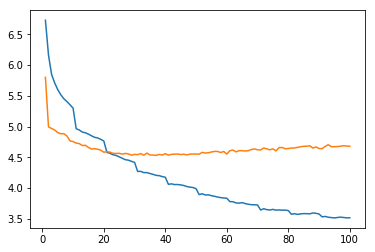

In [21]:
plot_loss(losses)

## reviews conditioned on genre

### genre tensor

In [22]:
#ALL_GENRES = list(set([GENRE_REGEX.sub('', genre.upper()) for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (6): ['NON-MUSIC', 'POP', 'R-B', 'RAP', 'COUNTRY', 'ROCK']


In [23]:
# one-hot vector for genres
def oneHotGenre(genres):
    enc = np.zeros(N_GENRES)
    for genre in genres:
        #genre_idx = ALL_GENRES.index(GENRE_REGEX.sub('', genre.upper()))
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[genre_idx] = 1
    return enc

print('r-b tensor:', oneHotGenre(['r-b']))

r-b tensor: [0. 0. 1. 0. 0. 0.]


In [24]:
def sample_fast_genre(model, seed='the song', genres=['pop'], sample=True):
    text_tensor = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    genre_tensor = genreTensor(genres)
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='the song', genres=['pop'], sample=True):
    res = seed
    for i in range(n):
        w = sample_fast_genre(model, seed, genre, sample)
        res += w + ' '
        seed = seed[1:]+w
    print(res)

### adding genre to languagemodelloader

let's look at the training data...

In [25]:
md.trn_ds.fields['text']

In [26]:
md.trn_dl.data

tensor([[ 1361,    14,    64,  ...,     2,    30,    14],
        [   54,    12,     2,  ...,   205,     7,    12],
        [    7,     0,   301,  ...,     0,   261,    36],
        ...,
        [    2,    94,    63,  ...,     7,     3,     0],
        [ 1032,   771,    61,  ...,    31,     9,   470],
        [    4,    12,    89,  ...,   375,     6,     2]], device='cuda:0')

In [27]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('honne', tensor([ 1361], device='cuda:0')),
 ('are', tensor([ 54], device='cuda:0')),
 ('a', tensor([ 7], device='cuda:0')),
 ('british', tensor([ 949], device='cuda:0')),
 ('duo', tensor([ 231], device='cuda:0')),
 ('who', tensor([ 105], device='cuda:0')),
 ('knocked', tensor([ 0], device='cuda:0')),
 ('me', tensor([ 75], device='cuda:0')),
 ('right', tensor([ 168], device='cuda:0')),
 ('off', tensor([ 167], device='cuda:0')),
 ('my', tensor([ 71], device='cuda:0')),
 ('feet', tensor([ 0], device='cuda:0')),
 ('last', tensor([ 123], device='cuda:0')),
 ('year', tensor([ 112], device='cuda:0')),
 ('when', tensor([ 94], device='cuda:0')),
 ('they', tensor([ 62], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('released', tensor([ 109], device='cuda:0')),
 ('"', tensor([ 9], device='cuda:0')),
 ('warm', tensor([ 561], device='cuda:0'))]

TorchText allows `Field`s to specify a postprocessing pipeline that applies "after numericalizing but before the numbers are turned into a Tensor" [(source)[http://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Field]].

Let's update the language model data to prepend the embedding to the beginning of the numericalized text!

In [ ]:
'''new_example = []
    print('EXAMPLE:\n', arr[0])
    #print('ALL_GENRES:\n', [f'genre{genre.upper()}' for genre in ALL_GENRES])
    for token in example:
        if not isinstance(token, str):
            new_token = token
        elif token in [f'genre{genre.upper()}' for genre in ALL_GENRES]:
            new_token = genreTensor([token[5:]])
        else:
            new_token = token.lower()

        #print('TOKENS:\n', token, new_token)
        new_example.append(new_token)
    #print('NEW_EXAMPLE:\n', new_example)
    return new_example'''

def special_token_to_genre(batch_list, vocab, train):
    genre_markers = [vocab.stoi[f'genre{genre.upper()}'] for genre in ALL_GENRES]
    
    #print('GENRE_MARKERS:\n', genre_markers)
    
    new_batch_list = []
    for batch in batch_list:
        new_batch = []
        for token_idx in batch:
            new_token = [token_idx]
            if token_idx in genre_markers:
                new_token = oneHotGenre([vocab.itos[token_idx][5:]]).tolist()
            new_batch.extend(new_token)
        new_batch_list.append(new_batch)
        
    #print('OLD_BATCH:\n', batch_list)
    #print('NEW_BATCH:\n', new_batch_list)
    return new_batch_list

In [ ]:
TEXT = data.Field(tokenize='spacy', postprocessing=special_token_to_genre)#, preprocessing=special_token_to_genre)
#TEXT.build_vocab()

md = LanguageModelData.from_dataframes('.', TEXT, 'genre_content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

In [ ]:
print(md.trn_ds[0].text[:20])
print(TEXT.numericalize([md.trn_ds[0].text[:12+5]]))

In [ ]:
md.trn_dl.data

In [ ]:
#md.trn_ds.fields['text'].preprocessing = special_token_to_genre

### training

In [ ]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(n_genres + vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, genres, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs_combined = torch.cat((genres, inputs), 1)
        inputs_combined = self.embedding(inputs_combined)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [ ]:
genre_lstm = GenreLSTM(md.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(g_lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, md, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)